# Import Packages

In [1]:
import torch
import numpy as np
from PIL import Image
import random
from torch.utils.data import Dataset
import os
import os.path as osp
import torch.optim as optim
from monai.losses import DiceFocalLoss
from monai.networks import one_hot
from tqdm import tqdm

from sklearn.model_selection import StratifiedShuffleSplit
from collections import defaultdict
from torchvision import transforms as T
from torchvision.transforms import functional as F

import matplotlib.pyplot as plt
from segment_anything.modeling import *
from functools import partial
import torch.nn as nn
from sklearn.metrics import confusion_matrix, jaccard_score

from datetime import datetime

# Settings

In [2]:
torch.cuda.is_available()

True

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"using device:{device}")
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
torch.backends.cudnn.enabled = True

using device:cuda


In [4]:
# set seeds
torch.manual_seed(2023)
torch.cuda.empty_cache()

# Transforms

In [12]:
def pad_if_smaller(img, size, fill=0):
    min_size = min(img.size)
    if min_size < size:
        ow, oh = img.size
        padh = size - oh if oh < size else 0
        padw = size - ow if ow < size else 0
        img = F.pad(img, (0, 0, padw, padh), fill=fill)
    return img


class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target, box):
        for t in self.transforms:
            image, target, box = t(image, target, box)
        return image, target, box


class RandomResize(object):
    def __init__(self, min_size, max_size=None):
        self.min_size = min_size
        if max_size is None:
            max_size = min_size
        self.max_size = max_size

    def __call__(self, image, target, box):
        size = random.randint(self.min_size, self.max_size)
        old_w, old_h = image.size
        image = F.resize(image, size)
        target = F.resize(target, size, interpolation=Image.NEAREST)
        new_w, new_h = image.size
        # Scale box coordinates
        scale_x = new_w / old_w
        scale_y = new_h / old_h
        box = box * [scale_x, scale_y, scale_x, scale_y]
        return image, target, box

class RandomHorizontalFlip(object):
    def __init__(self, flip_prob):
        self.flip_prob = flip_prob

    def __call__(self, image, target, box):
        if random.random() < self.flip_prob:
            image = F.hflip(image)
            target = F.hflip(target)
            w = image.size[0]
            # Adjust box for horizontal flip
            box = [w - box[2], box[1], w - box[0], box[3]]
        return image, target, box


class RandomCrop(object):
    def __init__(self, size):
        self.size = size

    def __call__(self, image, target, box):
        image = pad_if_smaller(image, self.size)
        target = pad_if_smaller(target, self.size, fill=255)
        crop_params = T.RandomCrop.get_params(image, (self.size, self.size))
        i, j, h, w = crop_params
        image = F.crop(image, i, j, h, w)
        target = F.crop(target, i, j, h, w)
        box = [max(0,box[0] - j), max(0,box[1] - i), min(box[2] - j,image.size[0]), min(box[3] - i,image.size[1])]
        return image, target, box


class ToTensor(object):
    def __call__(self, image, target, box):
        image = F.to_tensor(image)
        target = torch.as_tensor(np.asarray(target), dtype=torch.int64)
        return image, target, box


class Normalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, image, target, box):
        image = F.normalize(image, mean=self.mean, std=self.std)
        return image, target, box


class ColorJitter(object):
    def __init__(self, brightness=0, contrast=0, saturation=0, hue=0):
        self.brightness = brightness
        self.contrast = contrast
        self.saturation = saturation
        self.hue = hue

    def __call__(self, image, target, box):
        image = T.ColorJitter(brightness=self.brightness,
                              contrast=self.contrast,
                              saturation=self.saturation,
                              hue=self.hue)(image)
        return image, target, box


class RandomVerticalFlip(object):
    def __init__(self, flip_prob):
        self.flip_prob = flip_prob

    def __call__(self, image, target, box):
        if random.random() < self.flip_prob:
            image = F.vflip(image)
            target = F.vflip(target)
            h = image.size[1]
            # Adjust box for vertical flip
            box = [box[0], h - box[3], box[2], h - box[1]]
        return image, target, box

In [13]:
def get_dataset(imgdir, maskdir=None, oversample_factors = {1:16,3:8,4:8,5:32}, train=True, val=False, test=False,
                transforms=None, indices = None):
    dataset = Gleason(imgdir=imgdir, maskdir=maskdir, oversample_factors = oversample_factors,train=train,
                      val=val, test=test, transforms=transforms,indices = indices)

    return dataset


def get_transform(train):
    base_size = 1536
    crop_size = 1024
    if train:
        min_size,max_size = 0.5*base_size, 2.0*base_size
    else:
        min_size = max_size = crop_size
    transforms = []
    transforms.append(RandomResize(min_size, max_size))
    if train:
        transforms.append(ColorJitter(0.5, 0.5, 0.5, 0.5))
        transforms.append(RandomHorizontalFlip(0.5))
        transforms.append(RandomVerticalFlip(0.5))
        transforms.append(RandomCrop(crop_size))
    transforms.append(ToTensor())
    transforms.append(Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225]))

    return Compose(transforms)

In [24]:
image_path = '../../data/TrainImgs/slide001_core003.jpg'
mask_path = '../../data/labels/slide001_core003_classimg_nonconvex.png'
transforms = get_transform(train = True)
image = Image.open(image_path)
mask = Image.open(mask_path)
y_indices, x_indices = np.where(np.array(mask) > 0)
if x_indices.size > 0 and y_indices.size > 0:
    x_min, x_max = np.min(x_indices), np.max(x_indices)
    y_min, y_max = np.min(y_indices), np.max(y_indices)
    H, W = np.array(mask).shape
    x_min = max(0, x_min - random.randint(0, 60))
    x_max = min(W, x_max + random.randint(0, 60))
    y_min = max(0, y_min - random.randint(0, 60))
    y_max = min(H, y_max + random.randint(0, 60))
    box = np.array([x_min, y_min, x_max, y_max])
else:
    box = np.array([0, 0, 0,0])

image_, mask_, box_ = transforms(image, mask, box)

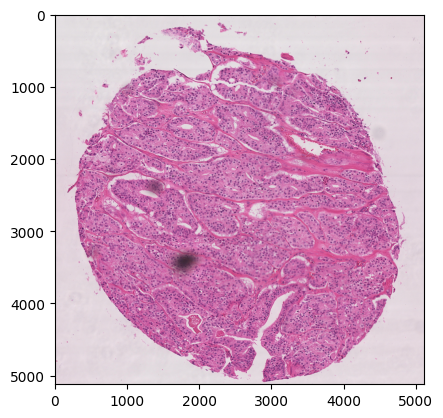

In [27]:
plt.imshow(F.to_tensor(image).permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.57667613..2.2914162].


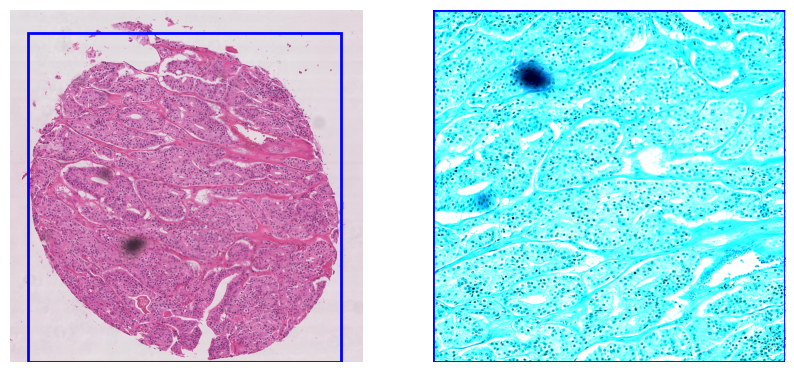

In [26]:
_, axs = plt.subplots(1, 2, figsize=(10, 10))
axs[0].imshow(F.to_tensor(image).permute(1, 2, 0))
show_box(box, axs[0])
axs[0].axis("off")
# set title
axs[1].imshow(image_.permute(1, 2, 0))
show_box(box_, axs[1])
axs[1].axis("off")
# set title
plt.show()
plt.subplots_adjust(wspace=0.01, hspace=0)
plt.close()

# loss plot

/tmp/ipykernel_206547/1287780222.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


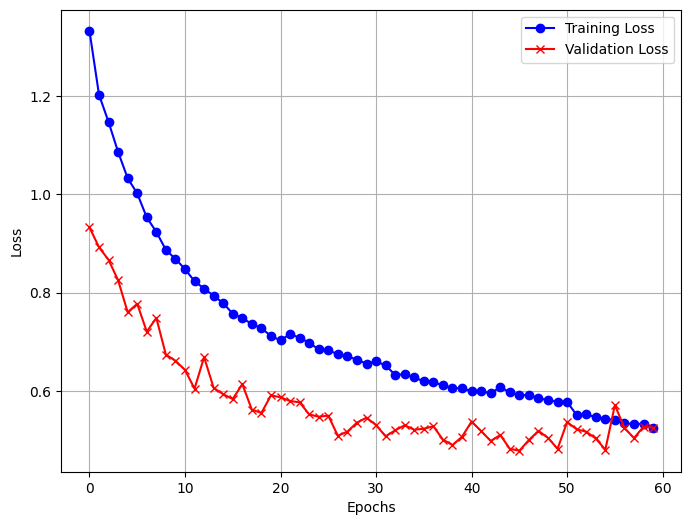

In [6]:
# 加载检查点
checkpoint_path = "checkpoint.pth"  # 替换为你的checkpoint路径
checkpoint = torch.load(checkpoint_path)

# 提取训练和验证损失
train_losses = checkpoint['train_losses']
val_losses = checkpoint['val_losses']

# 画损失曲线
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Training Loss', color='blue', marker='o')
plt.plot(val_losses, label='Validation Loss', color='red', marker='x')

# 添加标题和标签
#plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# 显示图像
plt.show()


# grading example

In [48]:
label_mapping = {0:0,1: 1, 3: 2, 4: 3, 5: 4}

class Gleason(Dataset):
    def __init__(self, imgdir, maskdir=None, oversample_factors = {}, train=True, val=False,
                 test=False, transforms=None,indices=None):
        super(Gleason, self).__init__()
        self.imgdir = imgdir
        self.maskdir = maskdir
        self.oversample_factors = oversample_factors
        self.imglist = sorted(os.listdir(imgdir))[1:]
        self.masklist = [item.replace('.jpg', '_classimg_nonconvex.png') for item in self.imglist]
        if indices is not None:
            self.masklist = [self.masklist[i] for i in indices]
        self.oversampled_files = self._apply_oversampling()
        self.train = train
        self.val = val
        self.test = test
        self.transforms = transforms
        
    def _apply_oversampling(self):
        oversampled_files = []
        for file in self.masklist:
            gt_file = osp.join(self.maskdir, file)
            gt = Image.open(gt_file)
            unique_classes = np.unique(np.array(gt))
            if max(unique_classes)<6:
                factor = max(self.oversample_factors.get(cls,1) for cls in unique_classes)
                oversampled_files.extend([file]*factor)
        return oversampled_files

    def __len__(self):
        return len(self.oversampled_files)

    def __getitem__(self, idx):
        image = Image.open(osp.join(self.imgdir, self.oversampled_files[idx].replace('_classimg_nonconvex.png','.jpg')))
        mask = Image.open(osp.join(self.maskdir, self.oversampled_files[idx]))
        
        y_indices, x_indices = np.where(np.array(mask) > 0)
        if x_indices.size > 0 and y_indices.size > 0:
            x_min, x_max = np.min(x_indices), np.max(x_indices)
            y_min, y_max = np.min(y_indices), np.max(y_indices)
            H, W = np.array(mask).shape
            x_min = max(0, x_min - random.randint(0, 60))
            x_max = min(W, x_max + random.randint(0, 60))
            y_min = max(0, y_min - random.randint(0, 60))
            y_max = min(H, y_max + random.randint(0, 60))
            box = np.array([x_min, y_min, x_max, y_max])
        else:
            box = np.array([0, 0, 0,0])
        if self.transforms and not self.test:
            image, mask, box = self.transforms(image, mask, box)
            if box[0]>=box[2] or box[1]>=box[3]:
                box = np.array([0,0,0,0])

        gt = np.vectorize(lambda x: label_mapping.get(x, 5))(np.array(mask))
        mask = torch.as_tensor(gt, dtype=torch.int64)
        
        if self.test:
            return image
        else:
            return F.crop(image, 0, 0, 1024, 1024), F.crop(mask, 0, 0, 1024, 1024), np.floor(np.array(box))
            

In [49]:
def get_dataset(imgdir, maskdir=None, oversample_factors = {1:16,3:8,4:8,5:32}, train=True, val=False, test=False,
                transforms=None, indices = None):
    dataset = Gleason(imgdir=imgdir, maskdir=maskdir, oversample_factors = oversample_factors,train=train,
                      val=val, test=test, transforms=transforms,indices = indices)

    return dataset


def get_transform(train):
    base_size = 1536
    crop_size = 1024
    if train:
        min_size,max_size = 0.5*base_size, 2.0*base_size
    else:
        min_size = max_size = crop_size
    transforms = []
    transforms.append(RandomResize(min_size, max_size))
    if train:
        transforms.append(ColorJitter(0.5, 0.5, 0.5, 0.5))
        transforms.append(RandomHorizontalFlip(0.5))
        transforms.append(RandomVerticalFlip(0.5))
        transforms.append(RandomCrop(crop_size))
    transforms.append(ToTensor())
    transforms.append(Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225]))

    return Compose(transforms)

In [309]:
valid_dataset = get_dataset(imgdir='../../data/TrainImgs',
                          maskdir='../../data/labels',
                          oversample_factors = {1:1,3:1,4:1,5:1},
                          train=False,
                          val=True,
                          test=False,
                          transforms=get_transform(train=False),indices=[15,56])#11,13,15,29,41

In [310]:
def cat_list(images, fill_value=0):
    max_size = tuple(max(s) for s in zip(*[img.shape for img in images]))
    batch_shape = (len(images),) + max_size
    batched_imgs = images[0].new(*batch_shape).fill_(fill_value)
    for img, pad_img in zip(images, batched_imgs):
        pad_img[..., :img.shape[-2], :img.shape[-1]].copy_(img)
    return batched_imgs


def collate_fn(batch):
    images, targets, box = list(zip(*batch))
    batched_imgs = cat_list(images, fill_value=0)
    batched_targets = cat_list(targets, fill_value=255)
    return batched_imgs, batched_targets, box

valid_dataloader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=2,
        shuffle=False, num_workers=10,
        collate_fn=collate_fn, drop_last=True)

In [311]:
class MedSAM(nn.Module):
    def __init__(
        self,
        image_encoder,
        mask_decoder,
        prompt_encoder,
    ):
        super().__init__()
        self.image_encoder = image_encoder
        self.mask_decoder = mask_decoder
        self.prompt_encoder = prompt_encoder
        # freeze prompt encoder
        
        for param in self.prompt_encoder.parameters():
            param.requires_grad = False

    def forward(self, image, box, dropout_prob=0.2):
        image_embedding = self.image_encoder(image)  # (B, 256, 64, 64)
        image_embedding = nn.functional.dropout(image_embedding, p=dropout_prob, training=self.training)

        # do not compute gradients for prompt encoder
        with torch.no_grad():
            box_torch = torch.as_tensor(np.array(box), dtype=torch.float32, device=image.device)
            if len(box_torch.shape) == 2:
                box_torch = box_torch[:, None, :]  # (B, 1, 4)
            sparse_embeddings, dense_embeddings = self.prompt_encoder(
                points=None,
                boxes=box_torch,
                masks=None,
            )
        #sparse_embeddings = nn.functional.dropout(sparse_embeddings, p=dropout_prob, training=self.training)
        #dense_embeddings = nn.functional.dropout(dense_embeddings, p=dropout_prob, training=self.training)
        
        low_res_masks, _ = self.mask_decoder(
            image_embeddings=image_embedding,  # (B, 256, 64, 64)
            image_pe=self.prompt_encoder.get_dense_pe(),  # (1, 256, 64, 64)
            sparse_prompt_embeddings=sparse_embeddings,  # (B, 2, 256)
            dense_prompt_embeddings=dense_embeddings,  # (B, 256, 64, 64)
            multimask_output=True,
        )
        low_res_masks = nn.functional.dropout(low_res_masks, p=dropout_prob, training=self.training)
        ori_res_masks = nn.functional.interpolate(
            low_res_masks,
            size=(image.shape[2], image.shape[3]),
            mode="bilinear",
            align_corners=False,
        )
        return ori_res_masks

In [312]:
encoder_global_attn_indexes = [2, 5, 8, 11]

num_class_sam_model = MedSAM(
    image_encoder=ImageEncoderViT(
        depth=12,
        embed_dim=768,
        img_size=1024,
        mlp_ratio=4,
        norm_layer=partial(torch.nn.LayerNorm, eps=1e-6),
        num_heads=12,
        patch_size=16,
        qkv_bias=True,
        use_rel_pos=True,
        global_attn_indexes=encoder_global_attn_indexes,
        window_size=14,
        out_chans=256,
    ),
    mask_decoder=MaskDecoder(
        num_multimask_outputs=4,
        transformer=TwoWayTransformer(
            depth=2,
            embedding_dim=256,
            mlp_dim=2048,
            num_heads=8,
        ),
        transformer_dim=256,
        iou_head_depth=3,
        iou_head_hidden_dim=256,
    ),
    prompt_encoder=PromptEncoder(
        embed_dim=256,
        image_embedding_size=(64, 64),
        input_image_size=(1024, 1024),
        mask_in_chans=16,
    )
)

num_class_sam_model = num_class_sam_model.to(device)
num_class_model_state_dict = num_class_sam_model.state_dict()

In [313]:
best_model_path = "best_model.pth"
num_class_sam_model.load_state_dict(torch.load(best_model_path))

/tmp/ipykernel_206547/2699593970.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  num_class_sam_model.load_state_dict(torch.load(best_model_path))


<All keys matched successfully>

In [314]:
for step,(image,gt,boxes) in enumerate(tqdm(valid_dataloader)):
    torch.cuda.empty_cache()
    image, gt = image.to(device), gt.to(device)
    gt = gt.squeeze(1)  # shape: (2, 1024, 1024)
    with torch.no_grad():
        medsam_pred = num_class_sam_model(image, boxes)
    break

  0%|          | 0/1 [00:00<?, ?it/s]/tmp/ipykernel_206547/3278471729.py:72: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /opt/conda/conda-bld/pytorch_1727971112454/work/torch/csrc/utils/tensor_numpy.cpp:206.)
  target = torch.as_tensor(np.asarray(target), dtype=torch.int64)
  0%|          | 0/1 [00:05<?, ?it/s]


In [315]:
final_pred = medsam_pred.argmax(1).cpu().numpy()
gt = gt.cpu().numpy()

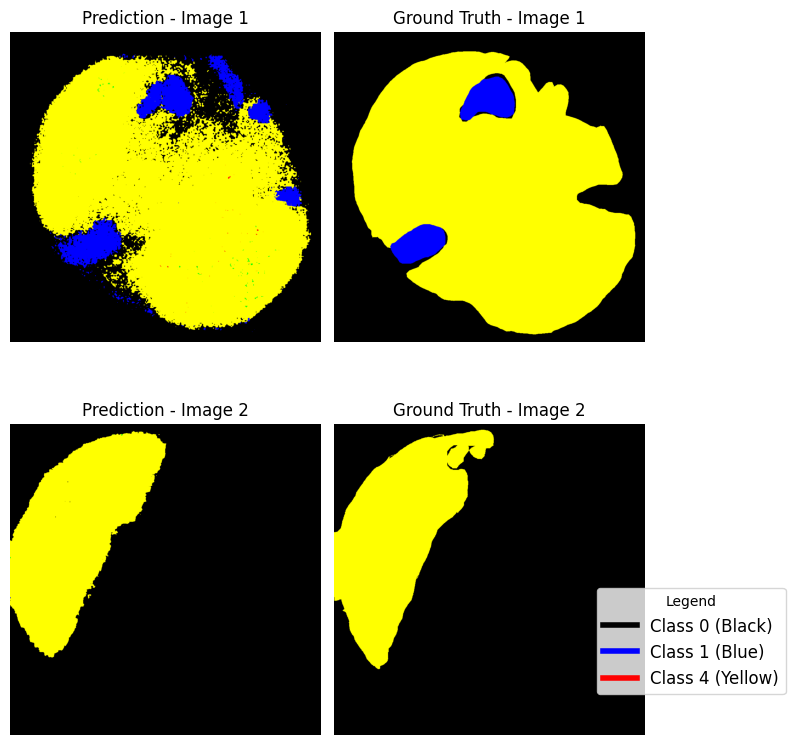

In [319]:
import matplotlib.pyplot as plt
import numpy as np

# 假设 final_pred 和 gt 是 2x1024x1024 的 numpy 数组
# final_pred = final_pred.numpy()
# gt = gt.numpy()

# 定义类别颜色（RGB 格式）
colors = {
    0: (0, 0, 0),        # 黑色
    1: (0, 0, 255),      # 蓝色
    2: (0, 255, 0),      # 绿色
    3: (255, 255, 0),    # 黄色
    4: (255, 0, 0)       # 红色
}

# 颜色与类别的图例映射
legend_labels = {
    0: 'Class 0 (Black)',
    1: 'Class 1 (Blue)',
    4: 'Class 4 (Yellow)'
}

def visualize_image(image, title, subplot_index):
    """ 将预测/真实数据可视化，使用不同颜色标记各类别 """
    h, w = image.shape
    color_map = np.zeros((h, w, 3), dtype=np.uint8)

    for class_id, color in colors.items():
        mask = image == class_id
        color_map[mask] = color  # 应用颜色
    
    plt.subplot(2, 2, subplot_index)
    plt.imshow(color_map)
    plt.title(title)
    plt.axis('off')

# 可视化第一张图片
plt.figure(figsize=(8, 8))
visualize_image(final_pred[0], "Prediction - Image 1", 1)
visualize_image(gt[0], "Ground Truth - Image 1", 2)

# 可视化第二张图片
visualize_image(final_pred[1], "Prediction - Image 2", 3)
visualize_image(gt[1], "Ground Truth - Image 2", 4)

# 添加图例
handles = [plt.Line2D([0], [0], color=np.array(colors[k]) / 255, lw=4, label=legend_labels[k]) for k in legend_labels.keys()]
plt.legend(handles=handles, loc='upper center', bbox_to_anchor=(1.15, 0.5), fontsize='large', title="Legend")

plt.tight_layout()
plt.show()
